In [3]:
import osmnx as ox
import os 
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qtagg import FigureCanvasQTAgg as FigureCanvas
from PyQt6.QtWidgets import QApplication, QDialog, QVBoxLayout, QLineEdit, QPushButton, QCheckBox, QLabel, QMessageBox
ox.__cached__ = True

In [4]:
app = QApplication(os.sys.argv)

0

RuntimeError: wrapped C/C++ object of type FigureCanvasQTAgg has been deleted

<Figure size 1252.5x612.5 with 1 Axes>

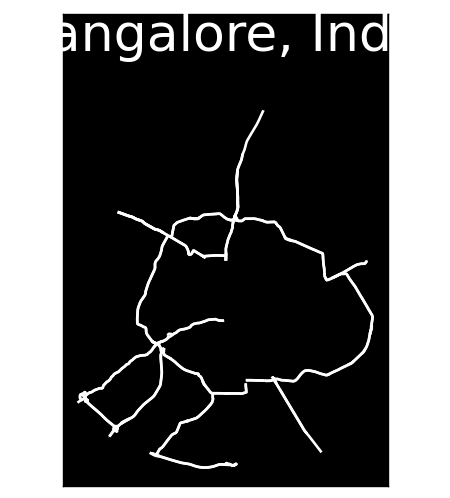

In [5]:
class InputDialog(QDialog):
    def __init__(self):
        super().__init__()

        self.setWindowTitle("City Road Network Mapper - OSM")
        self.setGeometry(100, 100, 1024, 920)

        layout = QVBoxLayout()

        layout.addWidget(QLabel("Which city do you want to view? (City, State (if any) , Country in full)"))
        self.text_input = QLineEdit()
        layout.addWidget(self.text_input)
        
        layout.addWidget(QLabel("Select the type of Network you want to print"))
        self.checkbox_group = []
        choices = ["motorway","trunk","primary","secondary","tertiary","motorway_link","trunk_link"]
        for choice in choices:
            checkbox = QCheckBox(choice)
            self.checkbox_group.append(checkbox)
            layout.addWidget(checkbox)

        layout.addWidget(QLabel("Which color you want it to be printed in? HEX Values with #"))
        # for choice in choices:
        #     layout.addWidget(QLabel("Color for: "+choice))
        #     color_text = QLineEdit()

        self.color_hex = QLineEdit()
        layout.addWidget(self.color_hex)

        submit_button = QPushButton("Submit")
        submit_button.clicked.connect(self.submit_clicked)
        layout.addWidget(submit_button)

        self.setLayout(layout)

    def submit_clicked(self):
        try:
            self.geocode_city()
            selected_choices = [checkbox.text() for checkbox in self.checkbox_group if checkbox.isChecked()]

            formatted_choices = "|".join(selected_choices)
            self.selected_choices_str = f'["highway"~"{formatted_choices}"]'

            # Create the graph using OSMnx
            G = ox.graph_from_polygon(self.geocoded_city.geometry.to_list()[0], custom_filter=self.selected_choices_str)
            nodes, edges = ox.graph_to_gdfs(G)

            color_bcg = '#000000'

            f, ax = plt.subplots(1, 1, figsize=(700,700))
            ax.set_aspect('equal')
            edges.plot(ax=ax, color=self.color_hex.text())
            ax.set_facecolor(color_bcg)

            # Get rid of the ticks
            ax.set_xticks([])
            ax.set_yticks([])

            # Add the title
            ymin, ymax = ax.get_ylim()
            extension = 0.2 * (ymax - ymin)
            ax.set_ylim(ymin, ymax + extension)
            ax.set_title(self.text_input.text(), fontsize=30, color=self.color_hex.text(), y=0.9)

            # Create a canvas to display the figure
            canvas = FigureCanvas(f)

            # Add the canvas to the layout
            layout = self.layout()
            if hasattr(self, 'canvas'):
                layout.removeWidget(self.canvas)
                self.canvas.deleteLater()

            self.canvas = canvas
            layout.addWidget(canvas)

            self.setLayout(layout)
            
            # self.close()
        except Exception as ex:
            print(f"An error occured at:{ex}")
            QMessageBox.critical(self,"Error",f"An error occured at:{ex}")

    def geocode_city(self):
        self.geocoded_city = ox.geocode_to_gdf(self.text_input.text())
        
dialog = InputDialog()
dialog.exec()

In [5]:
# # download the road network and transform into gdf
# G = ox.graph_from_polygon(admin.geometry.to_list()[0],custom_filter='["highway"~"motorway|trunk|secondary|tertiary|tertiary_link|secondary_link|trunk_link|motorway_link|primary|primary_link"]')
# nodes, edges = ox.graph_to_gdfs(G)

# # visualize with matplotlib
# electric_blue = "#00FFFF"
# color_bcg = '#000000'

# f, ax = plt.subplots(1, 1, figsize=(12, 12))
# edges.plot(ax=ax, color=electric_blue)
# ax.set_facecolor(color_bcg)

# # get rid of the ticks
# for xlabel_i in ax.get_xticklabels(): xlabel_i.set_visible(False)
# for ylabel_i in ax.get_yticklabels(): ylabel_i.set_visible(False)
# for tick in ax.get_xticklines(): tick.set_visible(False)
# for tick in ax.get_yticklines(): tick.set_visible(False)

# # add the title
# ymin, ymax = plt.ylim()
# extension = 0.2 * (ymax - ymin)
# ax.set_ylim(ymin, ymax + extension)
# ax.set_title(city, fontsize=30, color=electric_blue, y=0.9)

NameError: name 'admin' is not defined